# Extract the Throughput

In [2]:
import pandas as pd
import matplotlib as mpl
import matplotlib.cm as cm 
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import os,sys,re

from astropy.io import fits
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
from matplotlib import gridspec
%matplotlib inline


In [3]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (12, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [4]:
pysynphot_root_path=os.environ['PYSYN_CDBS']
path_sed_calspec=os.path.join(pysynphot_root_path,'calspec')
# pysynphot
import pysynphot as S

In [5]:
import time
from datetime import datetime,date
import dateutil.parser
import pytz

import logging
import coloredlogs

import coloredlogs
import configparser
import argparse


In [6]:
from scipy import interpolate
from scipy.interpolate import UnivariateSpline

In [7]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel,WhiteKernel)

# Initialisation

In [8]:
# start with logs
#-----------------
logging.basicConfig()
logging.root.setLevel(logging.NOTSET)

handle = __name__

logger = logging.getLogger(handle)
# logging.getLogger().setLevel(logging.INFO)
logger.setLevel(logging.DEBUG)

# If you don't want to see log messages from libraries, you can pass a
# specific logger object to the install() function. In this case only log
# messages originating from that logger will show up on the terminal.
coloredlogs.install(level='DEBUG', logger=logger)
coloredlogs.install(fmt='%(asctime)s,%(msecs)03d %(hostname)s %(name)s[%(process)d] %(levelname)s %(message)s')

In [9]:
# set time
# date
today = date.today()
string_date = today.strftime("%Y-%m-%d")

# time
now = datetime.now()
current_time = now.strftime("%H:%M:%S")

tim = time.localtime()
current_time = time.strftime("%H:%M:%S", tim)

# timezones
tz_LA = pytz.timezone('America/Los_Angeles')
datetime_LA = datetime.now(tz_LA)
msg="LA time:"+  datetime_LA.strftime("%H:%M:%S")
logger.info(msg)

tz_NY = pytz.timezone('America/New_York')
datetime_NY = datetime.now(tz_NY)
msg="NY time:"+ datetime_NY.strftime("%H:%M:%S")
logger.info(msg)

tz_London = pytz.timezone('Europe/London')
datetime_London = datetime.now(tz_London)
msg="London time:"+ datetime_London.strftime("%H:%M:%S")
logger.info(msg)

tz_Paris = pytz.timezone('Europe/Paris')
datetime_Paris = datetime.now(tz_Paris)
msg="Paris time:"+ datetime_Paris.strftime("%H:%M:%S")
logger.info(msg)

msg="************************ START *********************"
logger.info(msg)


2020-09-30 19:23:05,543 MacBook-Pro-de-admin.local __main__[66378] INFO LA time:10:23:05
2020-09-30 19:23:05,546 MacBook-Pro-de-admin.local __main__[66378] INFO NY time:13:23:05
2020-09-30 19:23:05,549 MacBook-Pro-de-admin.local __main__[66378] INFO London time:18:23:05
2020-09-30 19:23:05,551 MacBook-Pro-de-admin.local __main__[66378] INFO Paris time:19:23:05
2020-09-30 19:23:05,552 MacBook-Pro-de-admin.local __main__[66378] INFO ************************ START *********************


In [10]:
# arguments
#----------

parser = argparse.ArgumentParser()
parser.add_argument("--config",action="store", dest="configfile",help=f" run generate -config configfilename, with by ex configfilename = default.ini")
#results_args = parser.parse_args()

results_args=""

In [11]:
# config file
# --------------
configfile = "config/default.ini"
#config_filename = results_args.configfile
config_filename = configfile
msg = f"Configuration file : {config_filename}"
logger.info(msg)


2020-09-30 19:23:05,565 MacBook-Pro-de-admin.local __main__[66378] INFO Configuration file : config/default.ini


# Configuration

In [12]:
# 1) CONFIGURATION
#------------------
logger.info('1) Configuration')

config = configparser.ConfigParser()

if os.path.exists(config_filename):
    config.read(config_filename)
else:
    msg = f"config file {config_filename} does not exist !"
    logger.error(msg)

2020-09-30 19:23:05,578 MacBook-Pro-de-admin.local __main__[66378] INFO 1) Configuration


In [13]:
config_section = config.sections()

In [14]:
if len(config_section) == 0:
    msg = f"empty config file {config_filename} !"
    logger.error(msg)

In [15]:
if 'GENERAL' in config_section:

    FLAG_DEBUG = bool(int(config['GENERAL']['FLAG_DEBUG']))
    FLAG_VERBOSE = bool(int(config['GENERAL']['FLAG_VERBOSE']))
    FLAG_PLOT   = bool(int(config['GENERAL']['FLAG_PLOT']))
    FLAG_PRINT  = bool(int(config['GENERAL']['FLAG_PRINT']))
    inputdir    = config['GENERAL']['inputdir']
    inputfile   = config['GENERAL']['inputfile']
    target      = config['GENERAL']['object']
    sedfilename = config['GENERAL']['sedfilename']
    WLMINSEL      = float(config['GENERAL']['WLMINSEL'])
    WLMAXSEL      = float(config['GENERAL']['WLMAXSEL'])
    normalisation_factor = float(config['GENERAL']['normalisation_factor'])
    NPOINTSVIEW       =    int(config['GENERAL']['NPOINTSVIEW']) 
    NPOINTSSAVE       =    int(config['GENERAL']['NPOINTSSAVE']) 
    outputfile_linearfit =  config['GENERAL']['outputfile_linearfit']
    outputfile_gp        =  config['GENERAL']['outputfile_gp']
    holodatadir      =  config['GENERAL']['holodatadir']
    

else:
    msg = f"Configuration file : empty section GENERAL in config file {config_filename} !"   
    logger.error(msg)

In [16]:
msg=f" Object observed {target}"
logger.info(msg)

2020-09-30 19:23:05,626 MacBook-Pro-de-admin.local __main__[66378] INFO  Object observed HD116405


In [17]:
# SELECT THE INPUT FILE
inputfilename = outputfile_linearfit
#inputfilename = outputfile_gp

# SED

In [18]:
s0=S.FileSpectrum(os.path.join(path_sed_calspec,sedfilename))

In [19]:
sed_w=s0.wave/10
sed_f=s0.flux*10
sed_idx=np.where(np.logical_and(sed_w>350,sed_w<1100))[0]
sed_w=sed_w[sed_idx]
sed_f=sed_f[sed_idx]

In [20]:
sed_m=-2.5*np.log10(sed_f)

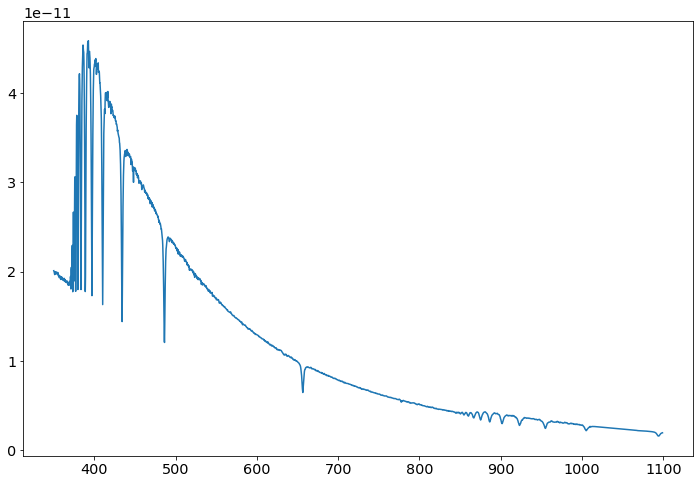

In [21]:
plt.plot(sed_w,sed_f)

# Holodata

In [22]:
list_of_files=os.listdir(holodatadir)

In [23]:
holo_files= []
for file in list_of_files:
    if re.search('.*holo.*[.txt]', file):
        holo_files.append(file)

In [24]:
holo_files=sorted(holo_files)

In [25]:
holo_files

['holo-2-1-order1.txt',
 'holo-2-2-order1.txt',
 'holo-2-4-order1.txt',
 'holo-3-100-1-order2_bis.txt',
 'holo-3-100-2-order0.txt',
 'holo-3-100-2-order1.txt',
 'holo-3-100-2-order2.txt',
 'holo-3-150-2-order0.txt',
 'holo-3-150-2-order1.txt',
 'holo-3-150-2-order1_bis.txt',
 'holo-3-150-2-order2.txt',
 'holo-3-200-1-order0.txt',
 'holo-3-200-1-order1.txt',
 'holo-3-200-1-order2.txt',
 'holo-3-70-2-order0.txt',
 'holo-3-70-2-order1.txt',
 'holo-3-70-2-order2.txt']

In [26]:
holodata1=np.loadtxt(os.path.join(holodatadir, holo_files[0]))
holodata2=np.loadtxt(os.path.join(holodatadir, holo_files[1]))
holodata3=np.loadtxt(os.path.join(holodatadir, holo_files[2]))
holotag1="holo-2-1"
holotag2="holo-2-2"
holotag3="holo-2-4"

# Throughput

In [27]:
df=pd.read_csv(inputfilename,index_col=0)

In [28]:
df

,wavelength,throu,errthrou,sedtoa,errsedtoa
0,385.000000,0.058991,0.006476,2.417099e-12,2.653299e-13
1,391.111111,0.077688,0.006802,3.412328e-12,2.987835e-13
2,397.222222,0.136028,0.010053,2.433674e-12,1.798577e-13
3,403.333333,0.106758,0.008729,4.558645e-12,3.727151e-13
4,409.444444,0.077835,0.005177,2.668393e-12,1.774695e-13
...,...,...,...,...,...
95,965.555556,0.038637,0.016486,1.214911e-13,5.183900e-14
96,971.666667,0.031767,0.013518,9.840477e-14,4.187524e-14
97,977.777778,0.045772,0.018885,1.411509e-13,5.823765e-14
98,983.888889,0.044353,0.018697,1.314001e-13,5.539299e-14


In [29]:
Y0=df["throu"]
EY0=df["errthrou"]
wl0=df["wavelength"]

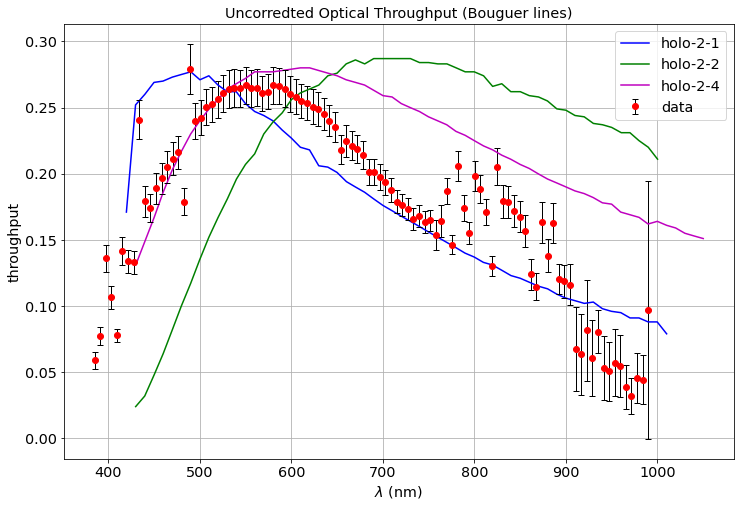

In [30]:
fig=plt.figure()
ax=fig.add_subplot(111)

# hologram data
ax.plot(holodata1[:,1],holodata1[:,2],"b-",label=holotag1 )
ax.plot(holodata2[:,1],holodata2[:,2],"g-",label=holotag2 )
ax.plot(holodata3[:,1],holodata3[:,2],"m-",label=holotag3 )

# pic du midi throughput
ax.errorbar(wl0,Y0,yerr=EY0,  fmt = 'o', color="r",capsize = 3, ecolor = 'k', elinewidth = 1, capthick = 1,label="data")
#ax.errorbar(w_s,transm_s,yerr=em_s,  fmt = 'o', color="r",ecolor = 'k', elinewidth = 1)
#ax.plot(w,transm,"or")

ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("throughput")
title=f"Uncorredted Optical Throughput (Bouguer lines)"
ax.set_title(title)
ax.grid()
ax.legend()

In [31]:
Y1=df["sedtoa"]
EY1=df["errsedtoa"]
wl1=df["wavelength"]

In [32]:
wl2_idx=np.where(np.logical_and(wl1>=WLMINSEL,wl1<=WLMAXSEL/2))[0]
wl2=wl1[wl2_idx]
Y2=Y1[wl2_idx]/2
EY2=EY1[wl2_idx]/2

2020-09-30 19:23:06,719 MacBook-Pro-de-admin.local numexpr.utils[66378] INFO NumExpr defaulting to 8 threads.


In [33]:
fcn2 = interpolate.interp1d(2*wl2,Y2,bounds_error=False,fill_value=(0,0))
fcn2e = interpolate.interp1d(2*wl2,EY2,bounds_error=False,fill_value=(0,0))

In [34]:
Y2interp=fcn2(wl1) 
EY2interp=fcn2e(wl1) 

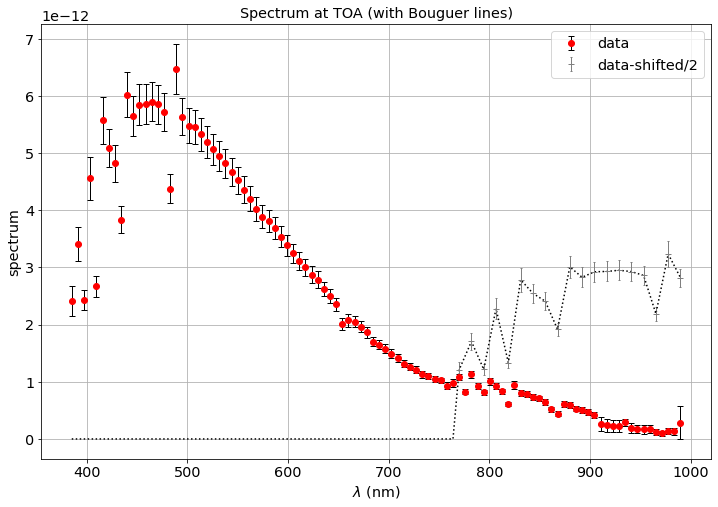

In [35]:
fig=plt.figure()
ax=fig.add_subplot(111)
ax.errorbar(wl1,Y1,yerr=EY1,  fmt = 'o', color="r",capsize = 3, ecolor = 'k', elinewidth = 1, capthick = 1,label="data")
#ax.errorbar(w_s,transm_s,yerr=em_s,  fmt = 'o', color="r",ecolor = 'k', elinewidth = 1)
#ax.plot(w,transm,"or")
ax.errorbar(2*wl2,Y2,yerr=EY2,  fmt = '+', color="grey",capsize = 1, ecolor = 'grey', elinewidth = 1, capthick = 1,label="data-shifted/2")
ax.plot(wl1,Y2interp,"k:")
#plt.plot(sed_w,sed_f,"b-",label="SED")
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("spectrum")
title=f"Spectrum at TOA (with Bouguer lines)"
ax.set_title(title)
ax.legend()
ax.grid()
#ax.set_yscale("log")

# Gaussian fit

In [36]:
idx_wl=np.where(wl1<750)[0]

In [37]:
x_to_fit=wl1[idx_wl]
y_to_fit=Y1[idx_wl]
ey_to_fit=EY1[idx_wl]

In [38]:
my_kernel=1e-24 * RBF(length_scale=100.0, length_scale_bounds=(100, 500.0))+WhiteKernel(noise_level=1e-26, noise_level_bounds=(1e-26, 1e-25))

In [39]:
gp = GaussianProcessRegressor(kernel=my_kernel,normalize_y=True,alpha=(5*ey_to_fit)**2,n_restarts_optimizer=10)


## Prior

In [40]:
X_ = np.linspace(x_to_fit.min(), x_to_fit.max(), 200)

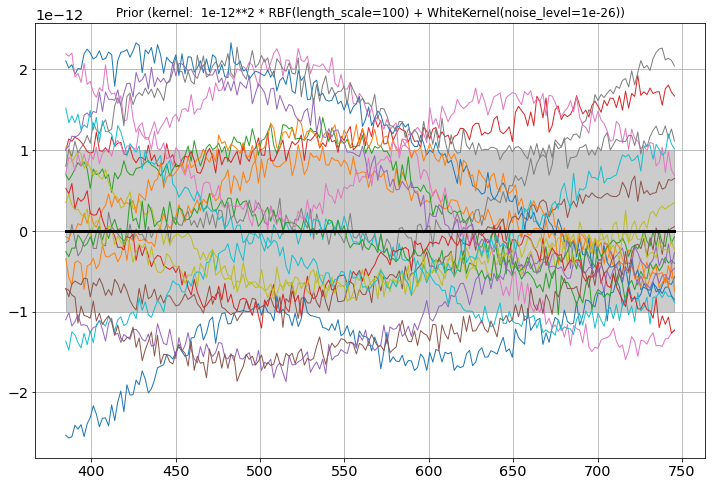

In [41]:

# Plot prior
fig=plt.figure()
fig.add_subplot(111)

y_mean, y_std = gp.predict(X_[:, np.newaxis], return_std=True)
plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
plt.fill_between(X_, y_mean - y_std, y_mean + y_std,alpha=0.2, color='k')
y_samples = gp.sample_y(X_[:, np.newaxis], 20)
plt.plot(X_, y_samples, lw=1)
plt.title("Prior (kernel:  %s)" % my_kernel, fontsize=12)
plt.grid()

## Gaussian fit

In [42]:
#gp.fit(x_to_fit[:, np.newaxis], y_to_fit)
#y_mean, y_std = gp.predict(X_[:, np.newaxis], return_std=True)

## Spline

In [43]:
spl = UnivariateSpline(x_to_fit, y_to_fit)
spl.set_smoothing_factor(10)

## Plot

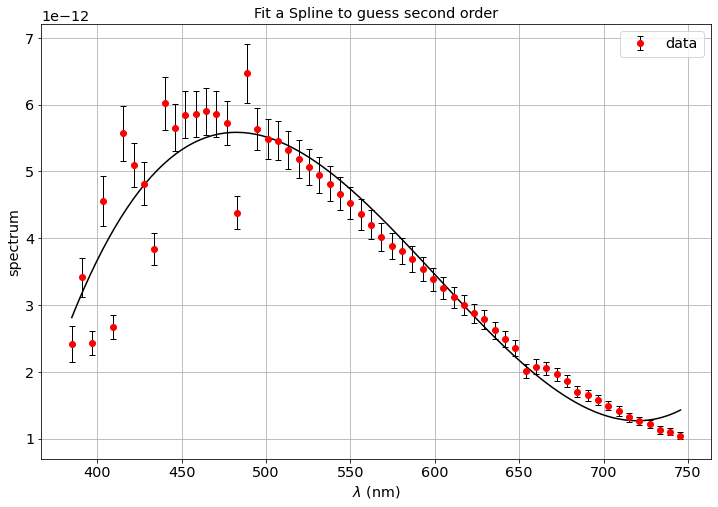

In [44]:
fig=plt.figure()
ax=fig.add_subplot(111)
ax.errorbar(x_to_fit,y_to_fit,yerr=ey_to_fit,  fmt = 'o', color="r",capsize = 3, ecolor = 'k', elinewidth = 1, capthick = 1,label="data")

#ax.plot(X_, y_mean, 'k', lw=3, zorder=9)
#ax.fill_between(X_, y_mean - y_std, y_mean + y_std,alpha=0.2, color='k')

ax.plot(X_,spl(X_),"k-")

ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("spectrum")
title=f"Fit a Spline to guess second order"
ax.set_title(title)
ax.legend()
ax.grid()
#ax.set_yscale("log"

In [45]:
fcn3 = interpolate.interp1d(2*wl2,spl(wl2)/2,bounds_error=False,fill_value=(0,0))

In [46]:
Y3interp=fcn3(wl1) 

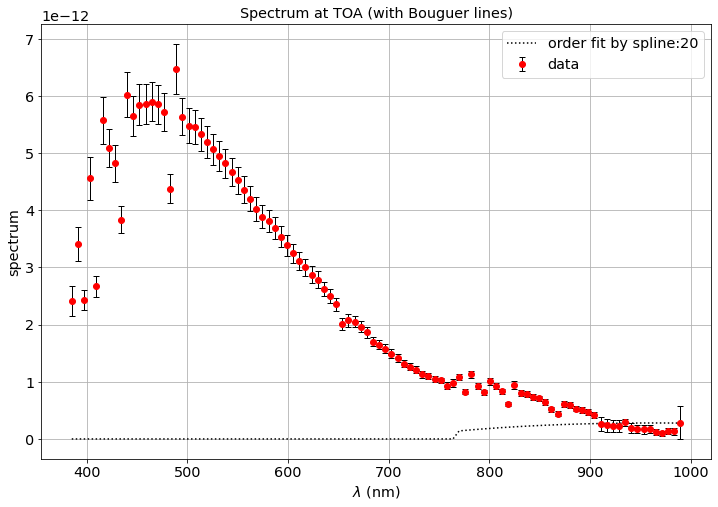

In [47]:
fig=plt.figure()
ax=fig.add_subplot(111)
ax.errorbar(wl1,Y1,yerr=EY1,  fmt = 'o', color="r",capsize = 3, ecolor = 'k', elinewidth = 1, capthick = 1,label="data")
#ax.errorbar(w_s,transm_s,yerr=em_s,  fmt = 'o', color="r",ecolor = 'k', elinewidth = 1)
#ax.plot(w,transm,"or")

ax.plot(wl1,Y3interp/10,"k:",label="order fit by spline:20")
#plt.plot(sed_w,sed_f,"b-",label="SED")
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("spectrum")
title=f"Spectrum at TOA (with Bouguer lines)"
ax.set_title(title)
ax.legend()
ax.grid()
#ax.set_yscale("log")